In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [58]:
import os
import pandas as pd

from fastai.vision import *
from fastai.metrics import error_rate

from fastai.callbacks.csv_logger import CSVLogger
from fastai.callbacks.tracker import SaveModelCallback

In [3]:
os.chdir(os.pardir)

In [69]:
from src.configs.constants import (
    DATA_DIR, CLASS_COL, IMG_COL, SAVED_DIR, TEST_DIR, WEIGHTS_FOLDER
)
from src.dataloaders.preprocess import get_indices_split

In [5]:
IMG_SIZE = 224
BATCH_SIZE = 32

# Loading Data

Visit **data block** API.

In [6]:
df = pd.read_csv(os.path.join(DATA_DIR, 'train_labels.csv'))
df.head()

,img_name,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
0,00001.jpg,39,116,569,375,Audi TTS Coupe 2012
1,00002.jpg,36,116,868,587,Acura TL Sedan 2012
2,00003.jpg,85,109,601,381,Dodge Dakota Club Cab 2007
3,00004.jpg,621,393,1484,1096,Hyundai Sonata Hybrid Sedan 2012
4,00005.jpg,14,36,133,99,Ford F-450 Super Duty Crew Cab 2012


## Train/Val/Test Splits

DataBunch does the split for us.  
Consider **Stratified Split**?

In [31]:
train_idx, val_idx = get_indices_split(df, CLASS_COL, 0.2)
# 
# val_df = training_df.iloc[val_indices]
# train_df = training_df.iloc[train_indices]
# 
# print(f'Train Size: {len(train_df)}')
# print(f'Val Size: {len(val_df)}')

## Define Augmentations

Possibly too much cropping.

In [8]:
tfms = get_transforms()

## Create DataBunch

In [9]:
# Set random seed for validation split
# np.random.seed(42)

# data = ImageDataBunch.from_csv(
#     DATA_DIR,
#     folder='train',
#     csv_labels='train_labels.csv',
#     valid_pct=0.2,
#     fn_col=IMG_COL,
#     label_col=CLASS_COL,
#     ds_tfms=tfms,
#     size=IMG_SIZE,
#     bs=BATCH_SIZE
# )\
#     .normalize(imagenet_stats)

In [32]:
src = (ImageList.from_csv(DATA_DIR, 'train_labels.csv', folder='train', cols=IMG_COL)
       # stratified split
       .split_by_idxs(train_idx, val_idx)
       .label_from_df(CLASS_COL))

In [36]:
data = (src.transform(tfms, size=IMG_SIZE)
        .databunch(bs=BATCH_SIZE)
        .normalize(imagenet_stats))

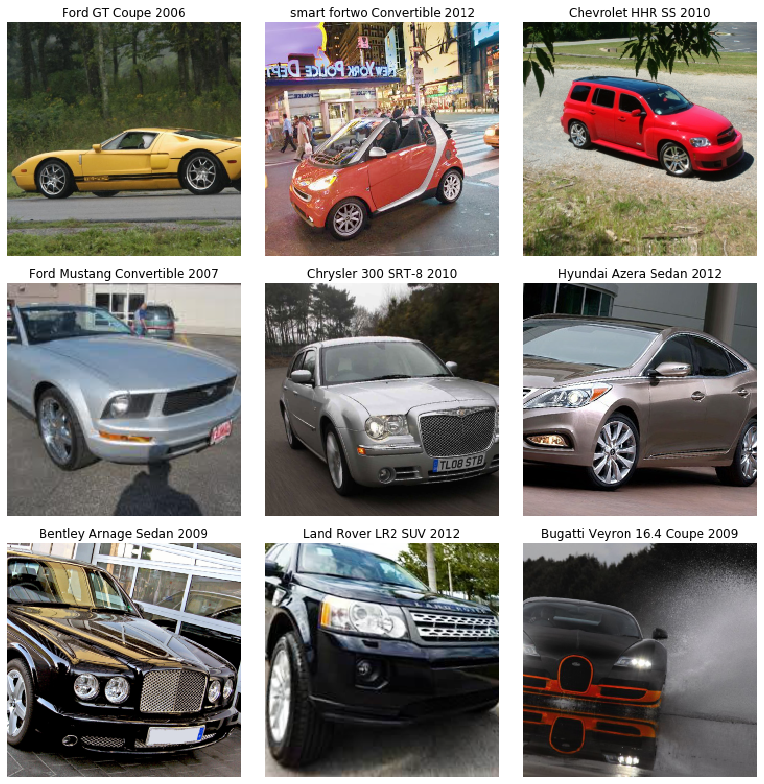

In [48]:
data.show_batch(rows=3, figsize=(11,11))

In [39]:
len(data.classes),data.c

(196, 196)

In [40]:
data.train_ds

LabelList (6515 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
AM General Hummer SUV 2000,Lamborghini Diablo Coupe 2001,Hyundai Tucson SUV 2012,GMC Terrain SUV 2012,Ford Focus Sedan 2007
Path: data

In [41]:
data.valid_ds

LabelList (1629 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Ford Ranger SuperCab 2011,Toyota 4Runner SUV 2012,Aston Martin V8 Vantage Convertible 2012,Suzuki SX4 Sedan 2012,Audi RS 4 Convertible 2008
Path: data

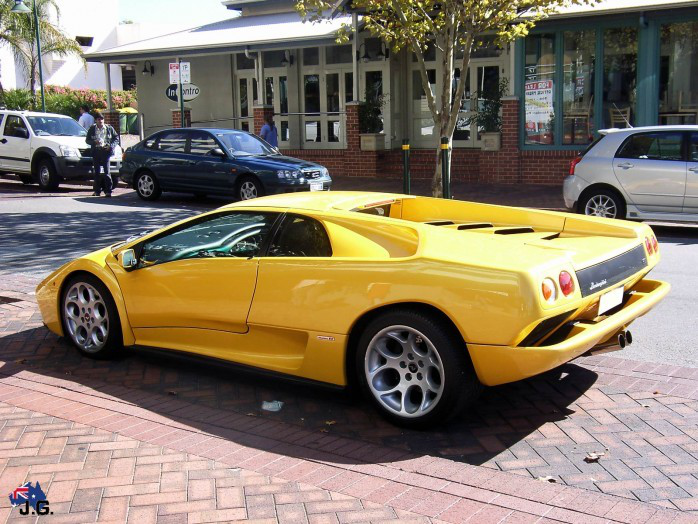

In [47]:
data.train_ds.x[1]

In [43]:
data.valid_ds.y[0]

Category Ford Ranger SuperCab 2011

In [72]:
np.array(data.valid_ds.y)

array([Category Ford Ranger SuperCab 2011, Category Toyota 4Runner SUV 2012,
       Category Aston Martin V8 Vantage Convertible 2012, Category Suzuki SX4 Sedan 2012, ...,
       Category Infiniti QX56 SUV 2011, Category Plymouth Neon Coupe 1999, Category Jeep Patriot SUV 2012,
       Category BMW 3 Series Wagon 2012], dtype=object)

# Training

## Define Metrics

In [61]:
precision = Precision('micro')
recall = Recall('micro')
fbeta = FBeta('micro')

In [62]:
metrics = [accuracy, precision, recall, fbeta]

## Define Callbacks

In [59]:
csv_logger = partial(
    CSVLogger, 
    append=True,
    filename='history'
)

saved_model_cb = partial(
    SaveModelCallback,
    every='improvement',
    monitor='valid_loss',
    name='bestmodel'
)

In [63]:
callbacks = [csv_logger, saved_model_cb]

## Stage-1

**Transfer learning**; only train the classifier head first.

In [66]:
learn = cnn_learner(
    data, 
    models.resnet50, 
    metrics=metrics, 
    path=SAVED_DIR,
    model_dir=WEIGHTS_FOLDER,
    callbacks=callbacks
)

Find the learning rate that results in a steep decrease in the network's loss;  
the part of the **steepest downward slope** (not the bottom), before the loss shoots up.

In [ ]:
learn.lr_find()

In [ ]:
# Indicates the point where the gradient is the steepest
learn.recorder.plot(suggestion=True)
learn.recorder.min_grad_lr

In [ ]:
learn.fit_one_cycle(4, lr)

In [ ]:
learn.save('stage-1')

## Stage 2

**Fine-tuning**; unfreeze all layers and train, but with discriminative layer training.

In [ ]:
learn.unfreeze()

**Discriminative layer training**
- Slower for earlier layers, faster for later layers, i.e. slice(start, end)
- 'start' should be inferred from the learning rate finder
    - At the bottom-ish, just before it shoots up, but 10x smaller.
- 'end' should be x5/10 smaller than lr used in Stage 1.

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, max_lr=slice(1e-6, 1e-4))

In [ ]:
learn.save('stage-2')

In [ ]:
learn.recorder.plot_losses()

## Increasing Image Size

Perform transfer learning with the already pretrained model with smaller image sizes.

In [ ]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

In [ ]:
learn.freeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, slice(lr))

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

## Saving / Loading

Only the parameters are saved, not the actual arhitecture (so you'll need to create your model in the same way before loading weights back in).

In [ ]:
learn.save()

In [ ]:
learn.load()

## Log Experiment Information

# Evaluation

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_top_losses(9, figsize=(15, 11))

In [ ]:
# interp.plot_confusion_matrix(figsize=(12, 12))

In [ ]:
interp.most_confused(min_val=2)

When evaluating test set, should go through the same transformations and normalization.

In [ ]:
learn.export('export.pkl')

In [ ]:
test_imgs = ImageList.from_folder(TEST_DIR)
learn = load_learner(test=test_imgs)

In [ ]:
preds, y = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
# precision, recall, fbeta
acc = accuracy(preds, y)

## Test time augmentation

Take the average of our regular predictions (with weight beta) with the average of predictions obtained through augmented version of the training set (with weight 1-beta).

In [ ]:
# Applies prediction using TTA
preds, y = learn.TTA(ds_type=DatasetType.Test)

# Cleaning Up

Remove samples that are invalid and don't belong (for entire dataset).  
Able to also look for and remove duplicates.

In [ ]:
# Create new dataset without the split
db = (ImageList.from_folder(path)
               .no_split()
               .label_from_folder()
               .transform(get_transforms(), size=224)
               .databunch())

# And also new learner
learn_cln = cnn_learner(db, models.resnet50, metrics=accuracy)
learn_cln.load('stage-2')

ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [ ]:
from fastai.widget import *

ImageCleaner(ds, idxs, path)

# Deploying

In [ ]:
learn.export()

In [ ]:
learn = load_learner(path)

In [ ]:
img = open_image()

In [ ]:
pred_class, pred_idx, outputs = learn.predict(img)

In [ ]:
learn.pred_batch(imgs)